In [1]:
import os 
os.chdir("../")
from tqdm.auto import tqdm
from skvideo.io import vwrite
from IPython.display import Video
from diffusion_policy.policy.diffusion_transformer_lowdim_policy import DiffusionTransformerLowdimPolicy
from diffusion_policy.model.diffusion.transformer_for_diffusion import TransformerForDiffusion
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import collections
import random
from diffusion_policy.env.pusht.pusht_keypoints_env import PushTKeypointsEnv

device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt_path = "/work/pi_hzhang2_umass_edu/jnainani_umass_edu/Interp4Robotics/diffusionInterp/data/experiments/low_dim/pusht/diffusion_policy_transformer/train_2/checkpoints/latest.ckpt"
state_dict = torch.load(ckpt_path, map_location='cuda')
config = state_dict['cfg']
model_config = config['policy']['model']
model_config = {k: v for k, v in model_config.items() if not k.startswith('_target_')}
model = TransformerForDiffusion(**model_config)
noise_scheduler_config = config['policy']['noise_scheduler']
noise_scheduler = DDPMScheduler(**noise_scheduler_config)
policy_params = {
    'model': model,
    'noise_scheduler': noise_scheduler,
    'horizon': config['policy']['horizon'],
    'obs_dim': config['policy']['obs_dim'],
    'action_dim': config['policy']['action_dim'],
    'n_action_steps': config['policy']['n_action_steps'],
    'n_obs_steps': config['policy']['n_obs_steps'],
    'num_inference_steps': config['policy'].get('num_inference_steps', None),
    'obs_as_cond': config['policy'].get('obs_as_cond', False),
    'pred_action_steps_only': config['policy'].get('pred_action_steps_only', False),
}
policy = DiffusionTransformerLowdimPolicy(**policy_params)
policy.load_state_dict(state_dict['state_dicts']['model'])
policy.to('cuda')

/tmp/ipykernel_485999/1784614998.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location='cuda')


DiffusionTransformerLowdimPolicy(
  (model): TransformerForDiffusion(
    (input_emb): Linear(in_features=2, out_features=256, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
    (time_emb): SinusoidalPosEmb()
    (cond_obs_emb): Linear(in_features=20, out_features=256, bias=True)
    (encoder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): Mish()
      (2): Linear(in_features=1024, out_features=256, bias=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import collections
import random

n_seeds = 20  # Number of random seeds to sweep
seed_threshold = 10000
obs_horizon = 2

# Generate n_seeds random seeds greater than 10000
seeds = [random.randint(seed_threshold + 1, 10 * seed_threshold) for _ in range(n_seeds)]
seeds += [78540,
 90318,
 40021,
 25426,
 50788,
 13783,
 37540,
 47567,
 10301,
 83703,
 95830,
 87380,
 41517,
 89203,
 33539,
 92410,
 30636,
 87390,
 52752,
 84098]

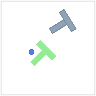

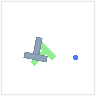

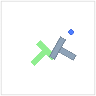

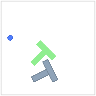

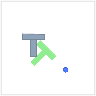

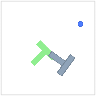

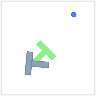

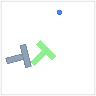

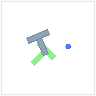

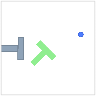

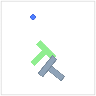

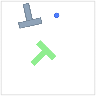

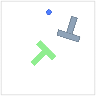

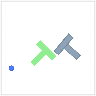

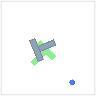

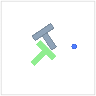

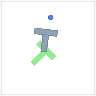

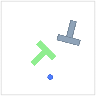

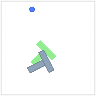

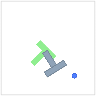

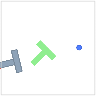

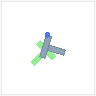

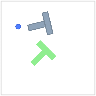

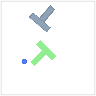

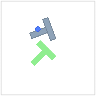

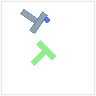

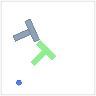

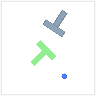

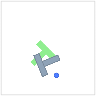

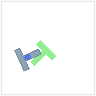

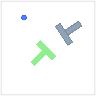

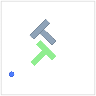

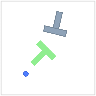

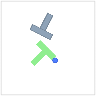

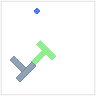

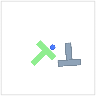

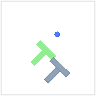

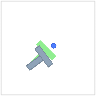

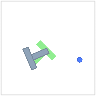

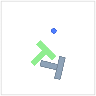

In [11]:
from PIL import Image
for seed in seeds:
    # Initialize environment and model for each seed
    env = PushTKeypointsEnv()
    env.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    obs = env.reset()
    img = env.render(mode='rgb_array')
    img_pil = Image.fromarray(img)
    # display img
    display(img_pil)

In [12]:
# save the list of seeds
import pickle
with open("data/seeds.pkl", "wb") as f:
    pickle.dump(seeds, f)

In [13]:
layer_num = 4
# handle = policy.model.decoder.layers[layer_num].register_forward_hook(intervene_with_sae(layer_num, sae))
for seed in seeds:
    # Initialize environment and model for each seed
    env = PushTKeypointsEnv()
    env.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    obs = env.reset()
    imgs = []  #
    obs_deque = collections.deque([obs[:20]] * obs_horizon, maxlen=obs_horizon)
    done = False
    max_steps = 200
    step_idx = 0
    rewards = []
    policy.to('cuda')
    inference_inputs = {}
    try: 
        with tqdm(total=max_steps, desc=f"Seed {seed} Eval") as pbar:
            while not done:
                B = 1
                obs_seq = np.stack(obs_deque)
                nobs = torch.from_numpy(obs_seq).unsqueeze(0).to('cuda', dtype=torch.float32)

                with torch.no_grad():
                    # Normalization and action inference logic from your code
                    nobs = policy.normalizer['obs'].normalize(nobs)
                    B, _, Do = nobs.shape
                    To = policy.n_obs_steps
                    T = policy.horizon
                    Da = policy.action_dim
                    device = policy.device
                    dtype = policy.dtype
                    cond = nobs[:, :To]

                    shape = (B, T, Da)
                    if policy.pred_action_steps_only:
                        shape = (B, policy.n_action_steps, Da)
                    cond_data = torch.zeros(size=shape, device=device, dtype=dtype)
                    cond_mask = torch.zeros_like(cond_data, dtype=torch.bool)

                    generator = None
                    trajectory = torch.randn(
                        size=cond_data.shape, 
                        dtype=cond_data.dtype,
                        device=cond_data.device,
                        generator=generator)
            
                    policy.noise_scheduler.set_timesteps(policy.num_inference_steps)

                    inference_inputs[step_idx] = []

                    for t in policy.noise_scheduler.timesteps:
                        trajectory[cond_mask] = cond_data[cond_mask]

                        step_input = {
                            "timestep": t,
                            "trajectory_input": trajectory.clone().cpu().numpy().tolist(),
                            "cond_input": cond.clone().cpu().numpy().tolist()
                        }

                        model_output = policy.model(trajectory, t, cond)

                        trajectory = policy.noise_scheduler.step(
                            model_output, t, trajectory, 
                            generator=generator,
                            **policy.kwargs
                        ).prev_sample

                        step_input["trajectory_output"] = trajectory.clone().cpu().numpy().tolist()
                        inference_inputs[step_idx].append(step_input)

                    trajectory[cond_mask] = cond_data[cond_mask]
                    naction_pred = trajectory[..., :Da]
                    action_pred = policy.normalizer['action'].unnormalize(naction_pred)

                    start = To - 1
                    end = start + policy.n_action_steps
                    action = action_pred[:, start:end]

                naction = action.detach().to('cpu').numpy()
                action = naction[0]

                for i in range(len(action)):
                    obs, reward, done, _ = env.step(action[i])
                    obs_deque.append(obs[:20])
                    rewards.append(reward)
                    imgs.append(env.render(mode='rgb_array'))
                    step_idx += 1
                    pbar.update(1)
                    if step_idx > max_steps:
                        done = True
                    if done:
                        print(f"Reward for {seed}: ", max(rewards))
                        break
        torch.save(inference_inputs, f"data/inference_inputs_seed_{seed}.pt")
    finally:
        # Remove hooks
        # handle.remove()
        torch.cuda.empty_cache()

/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')
Seed 47106 Eval: 201it [00:12, 15.96it/s]                         


Reward for 47106:  0.9556453670883237


Seed 54206 Eval:  91%|█████████ | 182/200 [00:10<00:01, 17.34it/s]


Reward for 54206:  1.0


Seed 30449 Eval:  94%|█████████▎| 187/200 [00:11<00:00, 16.85it/s]


Reward for 30449:  1.0


Seed 45429 Eval:  52%|█████▏    | 104/200 [00:05<00:05, 17.49it/s]


Reward for 45429:  1.0


Seed 90283 Eval: 201it [00:11, 16.79it/s]                         


Reward for 90283:  0.9917300847440728


Seed 60596 Eval: 201it [00:11, 16.84it/s]                         


Reward for 60596:  0.9764336015129591


Seed 23167 Eval: 201it [00:11, 16.97it/s]                         


Reward for 23167:  0.4619984317639395


Seed 30608 Eval: 201it [00:11, 16.87it/s]                         


Reward for 30608:  0.9564473515609531


Seed 55531 Eval:  81%|████████  | 162/200 [00:09<00:02, 16.77it/s]


Reward for 55531:  1.0


Seed 27242 Eval: 201it [00:11, 16.85it/s]                         


Reward for 27242:  0.9617650970114141


Seed 86172 Eval: 201it [00:11, 16.99it/s]                         


Reward for 86172:  0.9896661704109536


Seed 11446 Eval: 201it [00:11, 16.79it/s]                         


Reward for 11446:  0.8625132913023951


Seed 49442 Eval: 201it [00:11, 16.79it/s]                         


Reward for 49442:  0.46707589984243847


Seed 70799 Eval: 201it [00:11, 16.95it/s]                         


Reward for 70799:  0.6155558829588458


Seed 84003 Eval: 201it [00:11, 16.81it/s]                         


Reward for 84003:  0.900298839647354


Seed 29142 Eval: 201it [00:11, 16.80it/s]                         


Reward for 29142:  0.989500512397649


Seed 44578 Eval:  87%|████████▋ | 174/200 [00:10<00:01, 17.38it/s]


Reward for 44578:  1.0


Seed 32990 Eval: 201it [00:11, 17.01it/s]                         


Reward for 32990:  0.9921212357785126


Seed 98355 Eval: 201it [00:11, 16.86it/s]                         


Reward for 98355:  0.9898939976548201


Seed 27240 Eval: 201it [00:11, 16.86it/s]                         


Reward for 27240:  0.993277821121576


Seed 78540 Eval: 201it [00:11, 17.02it/s]                         


Reward for 78540:  0.9970216413140215


Seed 90318 Eval:  83%|████████▎ | 166/200 [00:09<00:01, 17.19it/s]


Reward for 90318:  1.0


Seed 40021 Eval:  95%|█████████▌| 190/200 [00:10<00:00, 17.41it/s]


Reward for 40021:  1.0


Seed 25426 Eval: 201it [00:11, 17.05it/s]                         


Reward for 25426:  0.0


Seed 50788 Eval:  61%|██████    | 122/200 [00:07<00:04, 16.47it/s]


Reward for 50788:  1.0


Seed 13783 Eval: 201it [00:11, 17.03it/s]                         


Reward for 13783:  0.0


Seed 37540 Eval: 201it [00:11, 16.87it/s]                         


Reward for 37540:  0.0


Seed 47567 Eval: 201it [00:11, 16.84it/s]                         


Reward for 47567:  0.9753735447613411


Seed 10301 Eval: 201it [00:11, 16.87it/s]                         


Reward for 10301:  0.7399153772780839


Seed 83703 Eval: 201it [00:11, 17.02it/s]                         


Reward for 83703:  3.468655399279247e-05


Seed 95830 Eval:  75%|███████▌  | 150/200 [00:08<00:02, 17.18it/s]


Reward for 95830:  1.0


Seed 87380 Eval: 201it [00:11, 16.83it/s]                         


Reward for 87380:  0.0


Seed 41517 Eval:  57%|█████▋    | 114/200 [00:06<00:05, 16.93it/s]


Reward for 41517:  1.0


Seed 89203 Eval: 201it [00:11, 16.85it/s]                         


Reward for 89203:  0.9197642184717941


Seed 33539 Eval:  91%|█████████ | 182/200 [00:10<00:01, 17.39it/s]


Reward for 33539:  1.0


Seed 92410 Eval: 201it [00:11, 16.82it/s]                         


Reward for 92410:  0.9413667072384447


Seed 30636 Eval:  46%|████▋     | 93/200 [00:05<00:06, 17.03it/s]


Reward for 30636:  1.0


Seed 87390 Eval:  70%|██████▉   | 139/200 [00:08<00:03, 16.73it/s]


Reward for 87390:  1.0


Seed 52752 Eval: 201it [00:11, 16.96it/s]                         


Reward for 52752:  0.9933639620821446


Seed 84098 Eval: 201it [00:11, 17.05it/s]                         

Reward for 84098:  0.9776663205567461


In [3]:
seeds_to_avoid = [87380, 37540, 13783, 25426, 70799, 49442, 23167, 45429]

In [5]:
import pickle 
#load the seeds
with open("data/seeds.pkl", "rb") as f:
    seeds = pickle.load(f)

In [6]:
from sae.sae_model import SparseAutoencoder
sae_path = "sae/results_layer4_dim2048_k64_auxk64_dead200/checkpoints/last.ckpt"
sae_weights = torch.load(sae_path)
ckpt = {}
for k in sae_weights['state_dict'].keys():
    if k.startswith('sae_model.'):
        ckpt[k.split(".")[1]] = sae_weights['state_dict'][k]
sae = SparseAutoencoder(256, 2048, 64, 64, 32, 200)
sae.load_state_dict(ckpt)
sae.to(device)

/tmp/ipykernel_485999/1721553749.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_weights = torch.load(sae_path)


SparseAutoencoder()

In [8]:
import torch
import pandas as pd
import os
from tqdm import tqdm

data_dir = "data"
output_df = []

# List of features we want to monitor
feature_list = [i for i in range(0, 2047)]

# Calculate total number of steps (files * step indices * timesteps)
seed_files = [f for f in os.listdir(data_dir) if f.endswith(".pt") and f.startswith("inference_inputs")]

print(feature_list)
print(seed_files)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
good_seed_list = []
for seed_file in seed_files:
    if int(seed_file.split("_")[-1].split(".")[0]) in seeds_to_avoid:
        continue
    good_seed_list.append(seed_file)
good_seed_list

In [10]:
# Initialize a single progress bar
total_steps = len(good_seed_list)
with tqdm(total=total_steps, desc="Processing All Seeds and Steps") as pbar:
    # Iterate over each saved .pt file in the directory
    for seed_file in seed_files:
        seed = int(seed_file.split('_')[-1].split('.')[0])  # Extract seed from filename
        inference_inputs = torch.load(os.path.join(data_dir, seed_file))
        
        # Iterate over each step_idx in the loaded data
        for step_idx, step_data in inference_inputs.items():
            # Each step contains multiple denoising steps, iterate through each timestep t
            for step_input in step_data:
                t = torch.Tensor([int(step_input["timestep"])]).to("cuda")
                trajectory_input = torch.tensor(step_input["trajectory_input"]).to("cuda", dtype=torch.float32)
                cond_input = torch.tensor(step_input["cond_input"]).to("cuda", dtype=torch.float32)
                layer_outs_data = {}
                
                def get_layer_out(layer_num):
                    def hook(module, input, output):
                        layer_outs_data[layer_num] = output.detach().cpu()
                    return hook

                layer_num = 4
                handle = policy.model.decoder.layers[layer_num].register_forward_hook(get_layer_out(layer_num))

                try:
                    with torch.no_grad():
                        model_output = policy.model(trajectory_input, t, cond_input)
                finally:
                    handle.remove()
                    torch.cuda.empty_cache()

                x = layer_outs_data[layer_num]
                x, mu, std = sae.LN(x.to('cuda'))
                x = x - sae.b_pre

                pre_acts = x @ sae.w_enc + sae.b_enc

                # latents: (BATCH_SIZE, D_EMBED, D_HIDDEN)
                latents = sae.topK_activation(pre_acts, k=sae.k)
                feature_acts = latents.flatten(0, 1)
                fired_mask = (feature_acts[:, feature_list]).sum(dim=-1) > 0
                selected_acts = feature_acts[fired_mask][:, feature_list]

                # Log only non-zero activations in the data_row
                data_row = {
                    "seed": seed,
                    "step_idx": step_idx,
                    "timestep": t[0].detach().cpu().item(),
                    **{f"feature_{i}": selected_acts[:, idx].mean().item()
                       for idx, i in enumerate(feature_list) if (selected_acts[:, idx] > 0).any()}
                }
                output_df.append(data_row)
                
                # Update the progress bar after each timestep
        pbar.update(1)

# Convert output data to a DataFrame
activations_df = pd.DataFrame(output_df)
activations_df.to_csv("data/better_activations_summary.csv", index=False)
activations_df.head()

Processing All Seeds and Steps:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_485999/2944529841.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inference_inputs =

,seed,step_idx,timestep,feature_36,feature_37,feature_43,feature_48,feature_60,feature_74,feature_81,...,feature_123,feature_998,feature_353,feature_813,feature_1536,feature_708,feature_2005,feature_1007,feature_815,feature_1687
0,10301,0,99.0,0.237614,0.085267,0.075548,0.075408,0.257446,0.205087,0.703572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10301,0,98.0,0.096594,0.196662,NaN,0.066946,NaN,0.154204,0.067845,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10301,0,97.0,NaN,NaN,0.111002,0.065571,0.111160,0.064492,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10301,0,96.0,0.060422,NaN,NaN,NaN,0.112508,NaN,0.320744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10301,0,95.0,0.063720,0.088817,NaN,NaN,NaN,0.164314,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
